In [1]:
source("~/common//scripts/loadCommonPackagesR.r")
library(rjson)
library(ggpubr)
library(rstatix)


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [2]:
setwd("/NAS392047/projects/yujw/2021.05.21.dingsheng/2Cell.induce/")

In [3]:
`+` <- function (e1, e2) UseMethod("+")
`+.default` <- function (e1, e2) .Primitive("+")(e1, e2)
`+.character` <- function(e1, e2) 
    if(length(e1) == length(e2)) {
           paste(e1, e2, sep = '')
    } else stop('String Vectors of Different Lengths')

In [4]:
readComputeMatrixResult<-function(dfPath,offset=6){
  library(rjson)
  library(tidyverse)
  
  df<-read_tsv(file=dfPath,col_names=F,col_types=cols(),skip=1)
  metadata<-readLines(gzfile(dfPath),1)%>%str_remove("^@")%>%fromJSON(json_str=.)
  dfSplited<-list()
  for(i in 1:length(metadata$sample_labels)){
    dfSplited<-c(
      dfSplited,
      df[
        (offset+1  +  metadata$sample_boundaries[i]):
        (offset  +  metadata$sample_boundaries[i+1])
      ]%>%list
    )
  }
  names(dfSplited)<-metadata$sample_labels
  return(dfSplited)
}

In [11]:
dfList<-readComputeMatrixResult("computeMatrix/allStageMERVL.75k.matrix.gz")

In [12]:
dfList<-lapply(dfList,function(df){
  df[is.na(df)]<-0
  df%>%colMeans(na.rm=TRUE)
})

In [13]:
plotDF<-dfList%>%as.data.frame%>%mutate(relativeCoordinate=row_number())%>%pivot_longer(cols = !relativeCoordinate,names_to = "condition",values_to = "signal")%>%mutate(condition=condition%>%str_remove("X"),condition=factor(condition,ordered = TRUE))

In [14]:
plotDF%>%head

relativeCoordinate,condition,signal
<int>,<ord>,<dbl>
1,mESC,1.266922
1,TLC,1.406649
1,2Cell_Early,1.376355
1,2Cell,1.339839
1,4Cell,1.300342
1,8Cell,1.326332


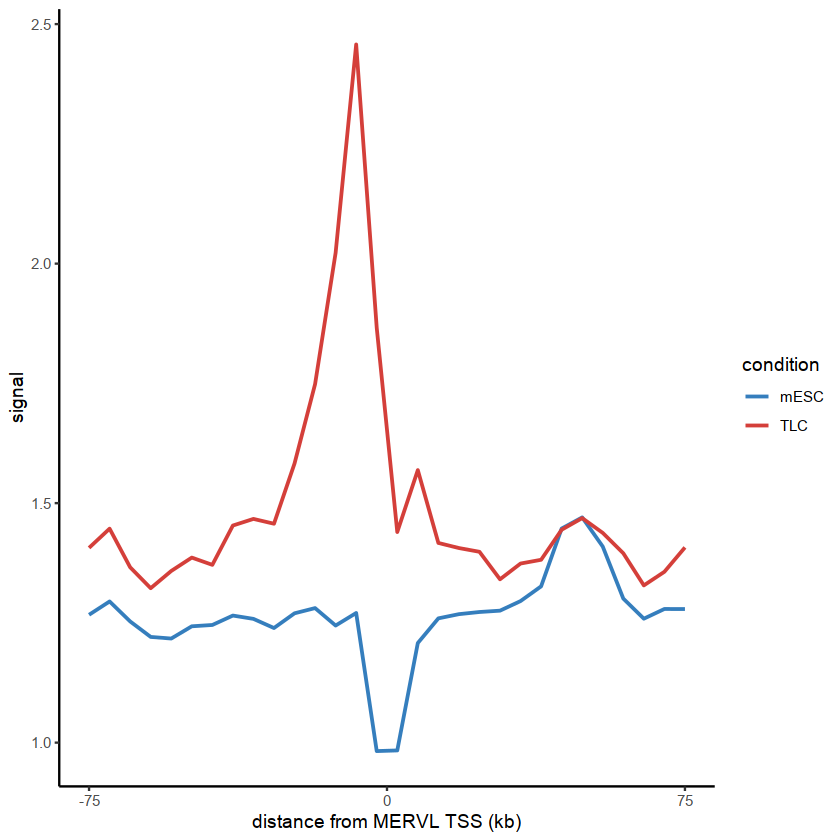

In [44]:
options(repr.plot.width=7)
ggplot(plotDF%>%filter(condition %in%c("TLC","mESC")))+
# ggplot(plotDF)+
geom_line(aes(x=relativeCoordinate,y=signal,color=condition),size=0.8)+
theme_classic()+
scale_x_continuous(
  breaks = c(1,15.5,30),
  labels = c("-75","0","75"),
  name = "distance from MERVL TSS (kb)"
)+
scale_color_manual(values = ggsci::pal_locuszoom()(5)[c(5,1)])
# scale_color_manual(values = ggsci::pal_locuszoom()(7)[c(5,1,2:4,6:7)])
ggsave("MERVLLinePlot.pdf",w=7,h=7)

In [17]:
repeatElementList<-"ERV1,ERVL,ERVK,MERVL-int,MT2-Mm"%>%str_split(string=.,pattern = ",")
repeatElementList<-repeatElementList[[1]]

In [18]:
plotLinePlot<-function(elementName){
  dfPath<-"computeMatrix/allStage"+elementName+".75k.5kBin.rpkm.matrix.gz"
  dfList<-readComputeMatrixResult(dfPath)
  dfList<-lapply(dfList,function(df){
    df[is.na(df)]<-0
    df%>%colMeans(na.rm=TRUE)
  })
  
  plotDF<-dfList%>%as.data.frame%>%mutate(relativeCoordinate=row_number())%>%pivot_longer(cols = !relativeCoordinate,names_to = "condition",values_to = "signal")%>%mutate(condition=condition%>%str_remove("X"),condition=factor(condition,ordered = TRUE))
#   return(plotDF)
  ggplot(plotDF%>%filter(condition %in%c("TLC","mESC")))+
  geom_line(aes(x=relativeCoordinate,y=signal,color=condition))
}

In [29]:
plotViolinPlot<-function(dfList,title){
  rowmeanList<-lapply(dfList,function(df){
    df[is.na(df)]<-0
#     df<-log10(df+1)
    df%>%rowSums
  })
  
  plotDF<-rowmeanList%>%
  as.data.frame%>%
  pivot_longer(cols = everything(), names_to = "condition",values_to = "signal")%>%
  mutate(condition=condition%>%str_remove("X"))%>%
  filter(condition %in% c("TLC","mESC"))%>%
  mutate(condition=factor(condition,ordered = TRUE))%>%
  arrange(condition)
#   print(plotDF%>%head)
  
  test<-plotDF%>%t_test(signal~condition)%>%add_significance()%>%adjust_pvalue()
  test<-test %>% add_xy_position(x="condition")
  test$custom.label <- ifelse(test$p.adj <= 0.05, test$p.adj, "Not Significant")
#   test$scientific.label <- ifelse(test$p.adj <= 0.05, format(test$p.adj,scientific=TRUE), "Not Significant")
  test$scientific.label <- ifelse(test$p.adj <= 10, format(test$p.adj,scientific=TRUE), "Not Significant")
#   print(test)
  
  ggplot(plotDF, aes(x=condition,y=signal))+
  geom_violin(aes(fill=condition))+
  geom_boxplot(width=0.2,outlier.shape = NA)+
  ggtitle(title)+
  stat_pvalue_manual(
    test,
    label="scientific.label",
    vjust=0
  )+
  theme_classic()+
#   ylim(c(-1,20))+
  scale_fill_manual(values = ggsci::pal_locuszoom()(5)[c(5,1)])
}

In [30]:
violinList<-lapply(repeatElementList,function(repeatElement){
  plotViolinPlot(readComputeMatrixResult("computeMatrix/2CellInduced"+repeatElement+".75k.5kBin.rpkm.matrix.gz"),title=repeatElement)
})

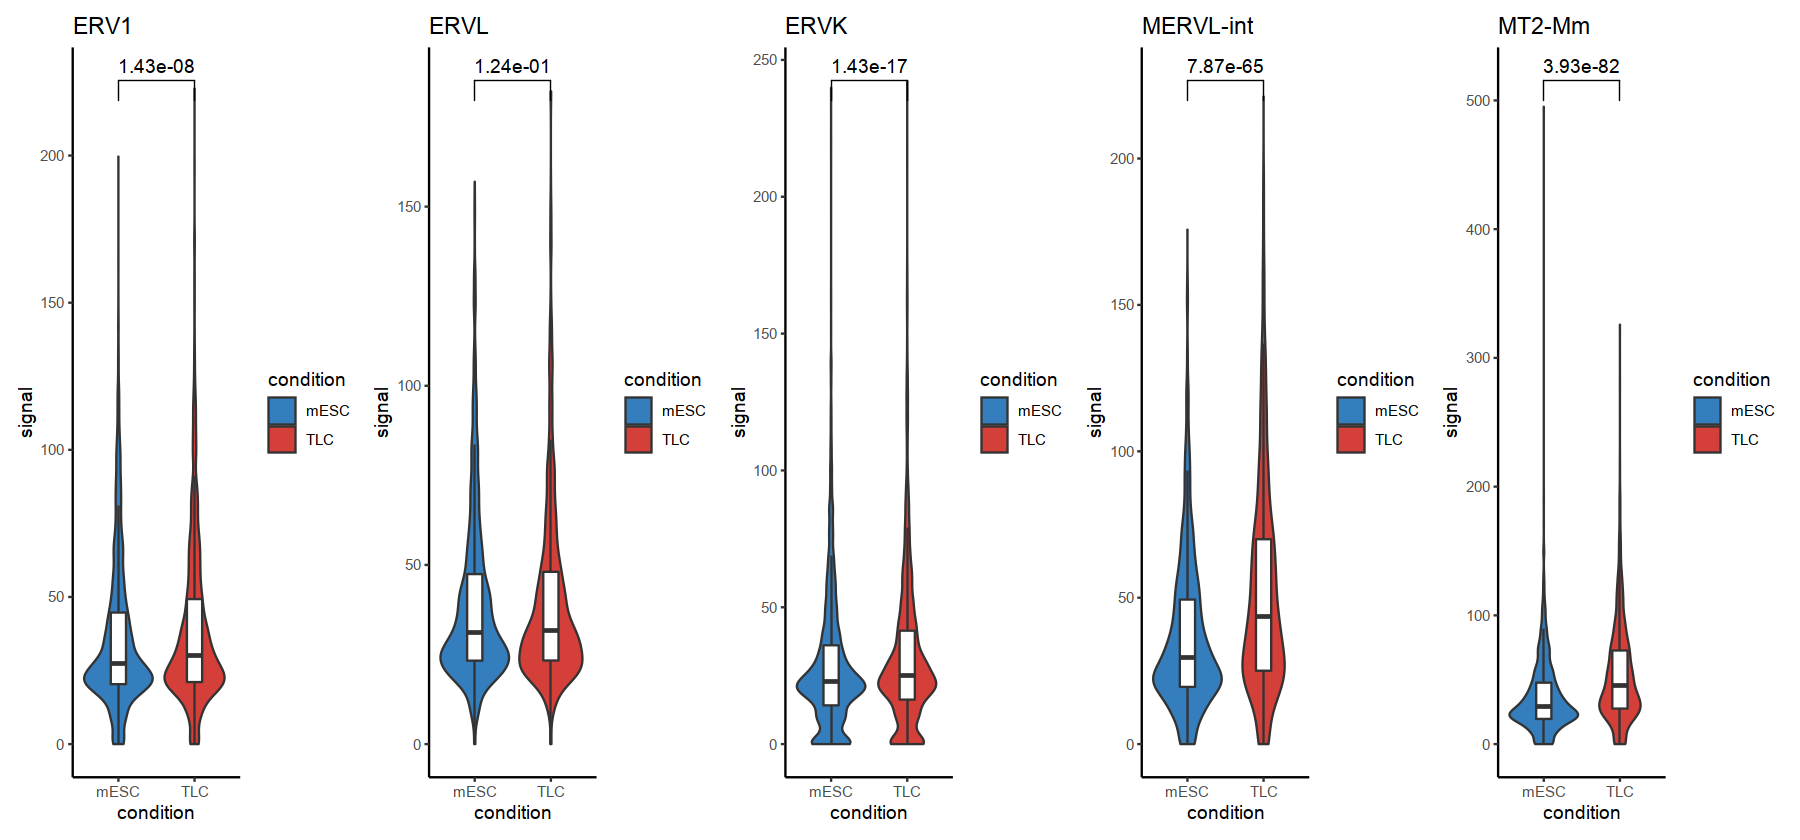

In [31]:
options(repr.plot.width=15)
violinList%>%wrap_plots(ncol = 5)

In [271]:
ggsave(filename = "moreRepeatElements.pdf",w=15,h=7)

logVersion

In [40]:
plotViolinPlot<-function(dfList,title){
  rowmeanList<-lapply(dfList,function(df){
    df[is.na(df)]<-0
    df<-log10(df+1)
    df%>%rowSums
  })
  
  plotDF<-rowmeanList%>%
  as.data.frame%>%
  pivot_longer(cols = everything(), names_to = "condition",values_to = "signal")%>%
  mutate(condition=condition%>%str_remove("X"))%>%
  filter(condition %in% c("TLC","mESC"))%>%
  mutate(condition=factor(condition,ordered = TRUE))%>%
  arrange(condition)
#   print(plotDF%>%head)
  
  test<-plotDF%>%t_test(signal~condition)%>%add_significance()%>%adjust_pvalue()
  test<-test %>% add_xy_position(x="condition")
  test$custom.label <- ifelse(test$p.adj <= 0.05, test$p.adj, "Not Significant")
#   test$scientific.label <- ifelse(test$p.adj <= 0.05, format(test$p.adj,scientific=TRUE), "Not Significant")
  test$scientific.label <- ifelse(test$p.adj <= 10, format(test$p.adj,scientific=TRUE), "Not Significant")
#   print(test)
  
  ggplot(plotDF, aes(x=condition,y=signal))+
  geom_violin(aes(fill=condition))+
  geom_boxplot(width=0.2,outlier.shape = NA)+
  ggtitle(title)+
  stat_pvalue_manual(
    test,
    label="scientific.label",
    vjust=0
  )+
  theme_classic()+
#   ylim(c(-1,7))+
  scale_fill_manual(values = ggsci::pal_locuszoom()(5)[c(5,1)])
}

In [41]:
violinList<-lapply(repeatElementList,function(repeatElement){
  plotViolinPlot(readComputeMatrixResult("computeMatrix/2CellInduced"+repeatElement+".75k.5kBin.rpkm.matrix.gz"),title=repeatElement)
})

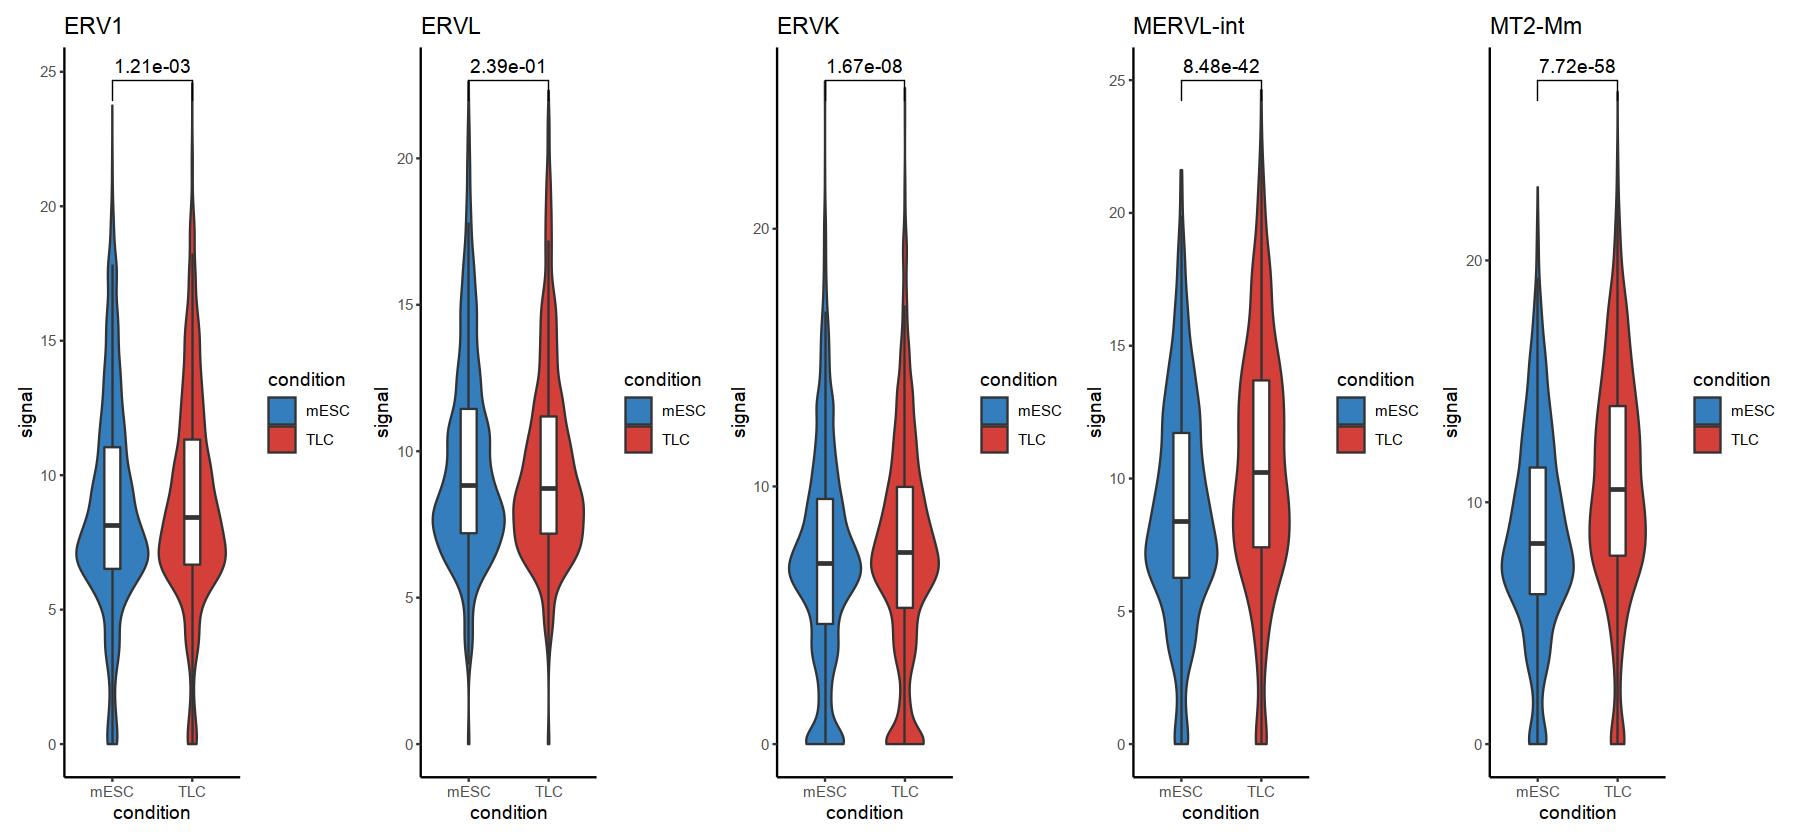

In [42]:
options(repr.plot.width=15)
violinList%>%wrap_plots(ncol = 5)

In [43]:
ggsave(filename = "moreRepeatElementsLogged.pdf",w=15,h=7)

In [64]:
t1<-plotLinePlot("ERVL")

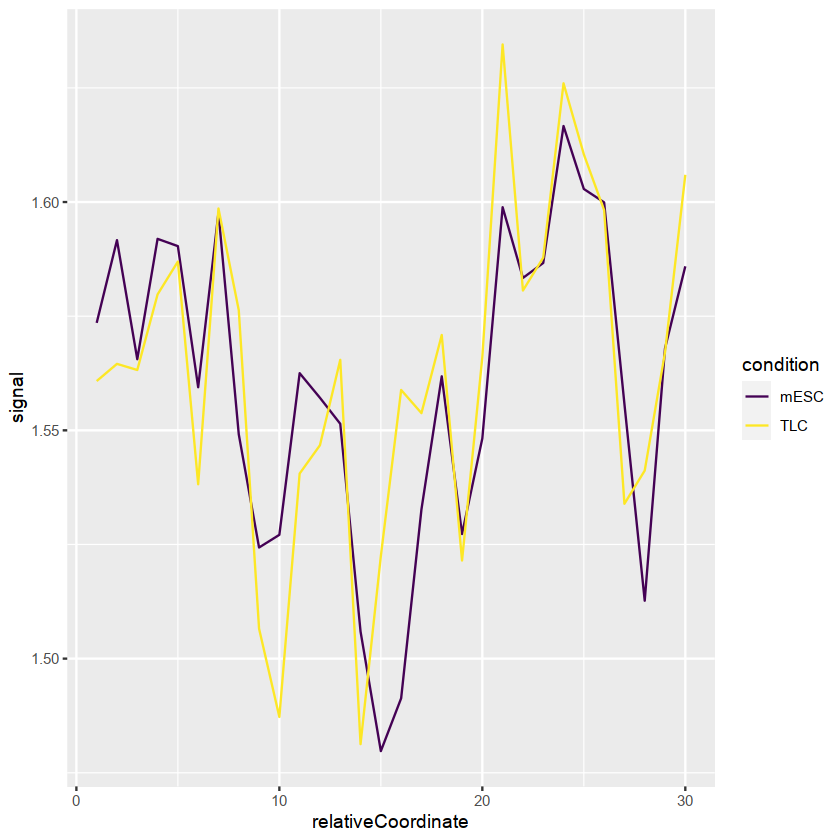

In [65]:
t1

In [34]:
t1<-readComputeMatrixResult("computeMatrix/allStageERV1.750k.matrix.gz")

In [35]:
t1%>%names

[1] "mESC"        "TLC"         "2Cell_Early" "2Cell"       "4Cell"      
[6] "8Cell"       "ICM"